In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 10.5 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_data = yf.download(tickers='AAPL', period='5y')

[*********************100%***********************]  1 of 1 completed


In [4]:
df = raw_data.copy()
df.shape

(1258, 6)

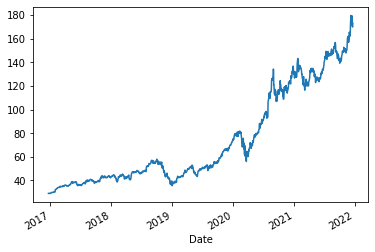

In [5]:
df.Close.plot()

In [6]:
#LSTM are sensitive to the scale of the data. Apply MinMax Scaler
df1 = df.reset_index()['Close']
df1 

0        29.072500
1        29.129999
2        29.315001
3        29.190001
4        29.182501
           ...    
1253    179.300003
1254    172.259995
1255    171.139999
1256    169.750000
1257    172.990005
Name: Close, Length: 1258, dtype: float64

In [7]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
df1 = scale.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[7.80758879e-04],
       [1.16282428e-03],
       [2.39211015e-03],
       ...,
       [9.44782234e-01],
       [9.35546050e-01],
       [9.57075042e-01]])

In [8]:
#train-test split
training_size = int(len(df1)*0.70)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:,:]

In [9]:
train_data.shape, test_data.shape

((880, 1), (378, 1))

In [10]:
train_data

array([[7.80758879e-04],
       [1.16282428e-03],
       [2.39211015e-03],
       [1.56151776e-03],
       [1.51168424e-03],
       [0.00000000e+00],
       [5.48194022e-04],
       [3.32231888e-04],
       [1.31233750e-03],
       [3.47188280e-03],
       [5.26595274e-03],
       [5.46529948e-03],
       [6.52845673e-03],
       [5.69786434e-03],
       [5.34901705e-03],
       [6.94375293e-03],
       [6.92713753e-03],
       [6.57829025e-03],
       [6.94375293e-03],
       [7.07665075e-03],
       [6.89391941e-03],
       [1.00667758e-02],
       [1.01664555e-02],
       [1.01830582e-02],
       [9.65147957e-03],
       [9.18634986e-03],
       [2.14791198e-02],
       [2.11136572e-02],
       [2.20273139e-02],
       [2.40373333e-02],
       [2.60972115e-02],
       [2.69444066e-02],
       [2.75756650e-02],
       [2.70773045e-02],
       [2.90208876e-02],
       [3.18947556e-02],
       [3.27087199e-02],
       [3.24429496e-02],
       [3.30575799e-02],
       [3.46855338e-02],


In [11]:
# convert an array into a dataset matrix #dataset[i: (i+time_step),0] - this ,0 will reduce the dimension
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i: (i+time_step),0])
        y.append(dataset[(i+time_step),0])
    return np.array(X), np.array(y)

In [12]:
#train-test split. time_step=100. X columns will be (X(t),x(t+1),X(t+2),......, X(t+100)). y -> 1 column (y(i+time_step))
X_train, y_train = create_dataset(train_data, time_step=100)
X_test, y_test = create_dataset(test_data, time_step=100)

In [13]:
X_test.shape, y_test.shape

((277, 100), (277,))

In [14]:
#Reshape to [samples, time_step, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
model = Sequential()
model.add(LSTM(25, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(25, return_sequences=True))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 25)           2700      
                                                                 
 lstm_1 (LSTM)               (None, 100, 25)           5100      
                                                                 
 lstm_2 (LSTM)               (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 12,926
Trainable params: 12,926
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=20, verbose=1)

Epoch 1/100
39/39 [==============================] - 18s 252ms/step - loss: 0.0053 - val_loss: 0.0130
Epoch 2/100
39/39 [==============================] - 8s 204ms/step - loss: 5.5381e-04 - val_loss: 0.0024
Epoch 3/100
39/39 [==============================] - 8s 194ms/step - loss: 4.6901e-04 - val_loss: 0.0020
Epoch 4/100
39/39 [==============================] - 4s 108ms/step - loss: 4.2408e-04 - val_loss: 0.0032
Epoch 5/100
39/39 [==============================] - 4s 101ms/step - loss: 3.8952e-04 - val_loss: 0.0022
Epoch 6/100
39/39 [==============================] - 4s 100ms/step - loss: 3.5368e-04 - val_loss: 0.0014
Epoch 7/100
39/39 [==============================] - 4s 99ms/step - loss: 3.1374e-04 - val_loss: 0.0071
Epoch 8/100
39/39 [==============================] - 4s 100ms/step - loss: 2.8611e-04 - val_loss: 0.0076
Epoch 9/100
39/39 [==============================] - 4s 99ms/step - loss: 2.3816e-04 - val_loss: 0.0145
Epoch 10/100
39/39 [==============================] - 4s 100

In [19]:
#predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [20]:
#inverse-transform - to retain the original data
train_predict = scale.inverse_transform(train_predict)
test_predict = scale.inverse_transform(test_predict)

In [21]:
#Metrics
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, train_predict, squared=False) #RMSE

53.38812856638123

In [22]:
mean_squared_error(y_test, test_predict, squared=False) #RMSE

129.91720134767178

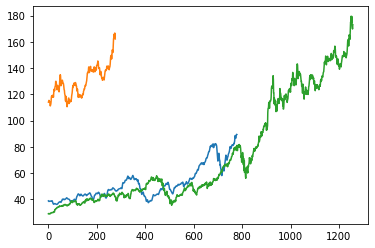

In [23]:
plt.plot(train_predict)
plt.plot(test_predict)
plt.plot(scale.inverse_transform(df1))

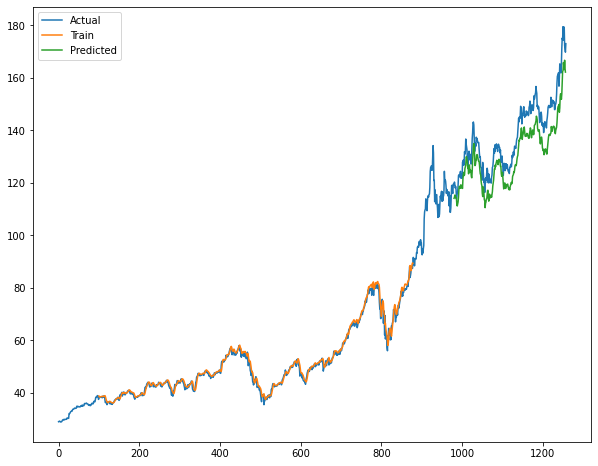

In [28]:
plt.figure(figsize=(10,8))
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scale.inverse_transform(df1), label='Actual')
plt.plot(trainPredictPlot, label='Train')
plt.plot(testPredictPlot, label='Predicted')
plt.legend()
plt.show()

In [34]:
rmse = np.sqrt(mean_squared_error(y_test, test_predict))
rmse

129.91720134767178